### Scaling figure

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import xarray as xr
import matplotlib.gridspec as gspec

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('paper')
sns.set_style('white')

In [4]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

In [5]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

def Z(U,f,L,W,N,s):
    '''depth of upwelling as in Howatt and Allen 2013'''
    return(1.8*(F(Ro(U,f,W))*Ro(U,f,L))**(0.5) *(1-0.42*SE(s,N,f,F(Ro(U,f,W)),Ro(U,f,L)))+0.05)


In [6]:
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
state = xr.open_dataset(state_file)
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [7]:
nz = 104
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
        
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    drc = nbl.variables['drC'][:] 

with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
   

In [8]:
sb_Ast =  29# 29 shelf break z-index Astoria

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear','Salinty','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane',
         'DIC', 'Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']

sb_conc_A = np.empty(len(labels))
sb_grad_A = np.empty(len(labels))
sb_curv_A = np.empty(len(labels))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array, sb_ind, grad_array, curv_array in zip([ptr_fileA],[sb_conc_A], [sb_Ast], 
                                                              [sb_grad_A], [sb_curv_A]):
        with Dataset(pfile, 'r') as nbl:
            
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180]
                sb_array[ii] = tr_profile[sb_ind]
                
            elif(trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = density.data*nbl.variables[trac][0,:,10,180]/1000
                sb_array[ii] = tr_profile[sb_ind]

            else:
                tr_profile = nbl.variables[trac][0,:,10,180]
                sb_array[ii] = tr_profile[sb_ind]
            
            tr_curv = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drc[3:]*drc[1:-2])
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
                
            curv_array[ii] = np.nanmean(tr_curv[sb_ind-2:sb_ind+2]) # local mean
            grad_array[ii] = np.nanmean(tr_grad[sb_ind-2:sb_ind+2]) 
                        

In [9]:
g = 9.81 # accel. gravity
Hs = 152.5 # Shelf break depth
s = 0.00230 # shelf slope 
N = np.array([5.5E-3,9.9E-3,5.5E-3,5.5E-3,])
f = np.array([1.0E-4,1.05E-4,1E-4,1E-4])
U = np.array([0.3,0.329,0.269,0.268]) 
Wiso = 8900
L = 21800
nz = 104
ny = 360
nx = 616
epsilons = np.array([5,5,5,25])    
Hrim = 120
Hh = 97.5
t = 6.5
R = 4500
kcans = np.array([1E-5,1E-5,1E-2,1E-2])
kbgs = np.array([1E-5,1E-5,1E-5,1E-5])

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

#RM&A2019
slope2 = 5
param2 = 0.86
intercept2 = -0.01

Linear -0.0 -2.5258425976633223
Salinty 8.522328104029606 2.649905837759948
Oxygen 5.859988699835416 4.234033906249909
Nitrate 2.747735855821072 2.0528210185277946
Silicate 7.605129213108507 2.070205650256963
Phosphate 7.242947706158106 2.366812369529956
Nitrous Oxide 16.6682684504507 8.983564745554505
Methane -7.643056173601988 -19.628260735165846
DIC 11.538670230893812 4.877546969093519
Alkalinity 13.412756590780972 4.836767907101704
RMSE 0 for Astoria is 5.215275e+09 
Linear -0.0 -3.357928698230216
Salinty 5.008813497114553 0.6553208481642745
Oxygen 3.4440812574202706 2.554675632142987
Nitrate 1.6149221519216903 0.0938340316886772
Silicate 4.469749742667937 0.2780554991798918
Phosphate 4.2568854175358535 0.4597715154098408
Nitrous Oxide 9.796413253400846 6.075948500712506
Methane -4.492040491076751 -18.729008977623664
DIC 6.781603158874819 2.853297361471239
Alkalinity 7.883056768683936 2.7992985551290523
RMSE 0 for ARGO is 1.857589e+09 


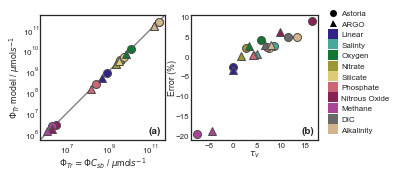

In [13]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(5,2.3))

exp_folders = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST']
exps = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03']
markers=['o','^']
run_labels=['Astoria', 'ARGO']

xx = np.linspace(0,5E11,20)
ax0.plot(xx,xx,color='0.5')

for uu, nn, ff, run_lab, fold, exp, mark in zip(U, N, f, run_labels, exp_folders, exps, markers):
    mse_0 = np.zeros(len(tracers))
    
    ii = 0
    for key, col, lab, C, grad, curv in zip(tracers, colours, labels, sb_conc_A, sb_grad_A, sb_curv_A):
        
        # --- get Phi_tr ----
        filename = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s_%s.csv' %(fold,key,exp))
        df = pd.read_csv(filename)
        HCW = 1000*df['HCW'][:] # *1000 to go from m^3/s to L/s

        if (key == 'Tr07' or key == 'Tr08'):
            TrMass = df['TrMassHCW'][:]
        else:
            TrMass = df['TrMassHCW'][:]*1E3

        PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        
        Se = SE(s, nn, ff, F(Ro(uu,ff,Wiso)), Ro(uu,ff,L))
        HA2013=1000*((slope*(F(Ro(uu,ff,Wiso))**(3/2))*(Ro(uu,ff,L)**(1/2))*((1-param*Se)**3))+intercept)*(uu*Wiso*Dh(ff,L,nn))
        
        ZZ = Z(uu,ff,L,Wiso,nn,s)*Dh(ff,L,nn)
        tau_v = -ZZ*curv/grad
       
        ax0.errorbar(HA2013*C, PhiTr, yerr=PhiTr_std, marker=mark,ms=8, c=col, label=lab, mec='0.3',mew=1)
        ax1.errorbar(tau_v,100*(((HA2013*C)-PhiTr)/PhiTr), marker=mark,ms=8, c=col, label=lab, mec='0.3',mew=1)
        mse_0[ii] = (PhiTr-HA2013*C)**2
        print(lab,tau_v,100*(((HA2013*C)-PhiTr)/PhiTr))
        ii=ii+1
    print('RMSE 0 for %s is %e ' %(run_lab,np.sqrt(np.sum(mse_0)/len(mse_0))))
    
legend_elements = [Line2D([0], [0], marker='o',color='w', label='Astoria',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   #Line2D([0], [0], marker='s',color='w', label='Barkley',
                   #       markerfacecolor='k', mec='k',markersize=7),
                   #Line2D([0], [0], marker='d',color='w', label='Pathways',
                   #       markerfacecolor='k', mec='k',markersize=7),
                   ]


ax0.legend(handles=legend_elements, bbox_to_anchor=(1.85,1), handletextpad=0)
for ii in range(len(colours)):
    legend_elements.append(Line2D([0], [0], marker='s',color='w', label=labels[ii],
                           markerfacecolor=colours[ii], mec=colours[ii],markersize=10),)

ax1.legend(handles=legend_elements, bbox_to_anchor=(1,1.1), handletextpad=0)
   
    
ax0.set_ylabel(r'$\Phi_{Tr}$ model / $\mu$mol$s^{-1}$', labelpad=0)
ax0.set_xlabel(r'$\Phi_{Tr}=\Phi C_{sb}$ / $\mu$mol$s^{-1}$', labelpad=0)
ax1.set_ylabel(r'Error (%)', labelpad=-2)
ax1.set_xlabel(r'$\tau_v$', labelpad=1)
ax1.set_xticks([-5,0,5,10,15])
ax0.set_xlim(5E5,5E11)
ax0.set_ylim(5E5,5E11)
ax0.set_aspect(1)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.yaxis.set_tick_params(pad=2)
ax1.xaxis.set_tick_params(pad=2)
ax0.yaxis.set_tick_params(pad=1)
ax0.xaxis.set_tick_params(pad=2)

ax0.text(0.87,0.05,'(a)',fontsize=10, fontweight='bold',  transform=ax0.transAxes)
ax1.text(0.87,0.05,'(b)',fontsize=10, fontweight='bold',  transform=ax1.transAxes)

plt.savefig('phitr_vs_scaling.eps',format='eps', bbox_inches='tight')

In [11]:
tau_v = -ZZ*curv
       

In [12]:
curv

-0.012449303129224064